In [1]:
import os
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
from datetime import datetime

In [2]:
path_input=os.path.join(os.getcwd(), '../data/input/dresden/')
path_output_weather = os.path.join(os.getcwd(), '../data/output/weather/')
path_output=os.path.join(os.getcwd(), '../data/output/')

## Read Data

In [3]:
directors = glob.glob(path_input+"*/**")

all_files = []
for director in directors:
    all_files=all_files+glob.glob(director+"/*.csv")
    
li = []

for filename in all_files:
    df_read = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_read)

df = pd.concat(li, axis=0, ignore_index=True)

In [4]:
#df["datetime"].sort_values()[1450300:1450350]

## Drop Columns

In [5]:
#Columns including single value
#The following columns only included one value (or NaN values)
#city : ['dresden']
#p_rack_locks : [False]
#b_state : ['ok']
#b_active : [ True]
#b_battery_pack : [nan '{"percentage": 0}']
#p_special_racks : [nan 0.]
#p_free_special_racks : [nan 0.]

#Columns which highly correlate

#The following columns highly correlate - meaning they are complementary booleans or if one is high, the other is too

#p_bike [corr(p_spot)=-0.999501, complementary boolean to p_spot]

df_cleaned = df.drop(["city", 
                      "p_bike", 
                      "p_rack_locks", 
                      "b_active", 
                      "b_state", 
                      "b_battery_pack", 
                      "p_rack_locks", 
                      "p_special_racks", 
                      "p_free_special_racks",
                      "p_address", # These 4 last columns will be dropped because there are too many stored NaN values
                      "p_bike_types",
                      "b_pedelec_battery",
                      "p_terminal_type"], axis=1)
df_cleaned.head()

,p_bike_racks,p_spot,p_booked_bikes,p_place_type,datetime,b_number,trip,p_uid,p_bikes,p_lat,b_electric_lock,b_bike_type,p_name,p_free_racks,b_lock_types,p_number,p_lng,b_boardcomputer,p_maintenance
0,0,True,0,0,2019-01-20 00:00:00,93716,first,264546,3,51.033548,False,15,Strehlener Platz,0,analog_code_lock,4346.0,13.748800,0,False
1,0,True,0,0,2019-01-20 09:40:00,93716,start,264546,3,51.033548,False,15,Strehlener Platz,0,analog_code_lock,4346.0,13.748800,0,False
2,0,True,0,0,2019-01-20 09:58:00,93716,end,264595,2,51.058771,False,15,Gutenbergstraße,0,analog_code_lock,4389.0,13.769281,0,False
3,0,True,0,0,2019-01-20 17:36:00,93716,start,264595,3,51.058771,False,15,Gutenbergstraße,0,analog_code_lock,4389.0,13.769281,0,False
4,0,True,0,0,2019-01-20 19:39:00,93716,end,100894,1,51.067153,False,15,Waldschlösschen,0,analog_code_lock,4361.0,13.776480,0,False


## Create Trips

In [6]:
# No Duplicates
len(df_cleaned)-len(df_cleaned.drop_duplicates(subset=df_cleaned.columns.difference(["p_lat", "p_lng"])))

0

In [7]:
print("Starts:", len(df_cleaned[df_cleaned["trip"]=="start"]))
print("Ends:", len(df_cleaned[df_cleaned["trip"]=="end"]))
print("Difference:", len(df_cleaned[df_cleaned["trip"]=="start"])-len(df_cleaned[df_cleaned["trip"]=="end"]))

Starts: 583206
Ends: 567439
Difference: 15767


In [8]:
# df_2: start and end of trips
df_2 = df_cleaned[(df_cleaned["trip"]=="start") | (df_cleaned["trip"]=="end")]
print("Dropped", len(df_cleaned)-len(df_2), "first and last Values")

Dropped 307709 first and last Values


In [9]:
# df_3: start and end of trips sorted by b_number and datetime
df_3=df_2.sort_values(["b_number", "datetime"])
df_3[["b_number", "datetime", "trip"]].iloc[500010:500030] # two examples for multiple starts

,b_number,datetime,trip
54359,93547,2019-02-12 21:52:00,start
54360,93547,2019-02-12 21:54:00,start
54361,93547,2019-02-12 21:56:00,end
54362,93547,2019-02-12 22:11:00,start
54363,93547,2019-02-12 22:14:00,end
54364,93547,2019-02-12 22:27:00,start
54365,93547,2019-02-12 22:30:00,end
54366,93547,2019-02-12 23:24:00,start
54367,93547,2019-02-12 23:27:00,start
54368,93547,2019-02-12 23:31:00,end


In [10]:
# sr_1: True if after start entry comes end entry else False
sr_1 = (df_3['trip'] != df_3['trip'].shift())
df_3["valid_start"]=sr_1

# sr_2: 
#sr_2 = (df_3['trip'] != df_3['trip'].shift(-1))
#df_3['valid_end'] = sr_2


In [11]:
# df_4: start and end of trips sorted by b_number and datetime only valid starts
df_4=df_3[df_3["valid_start"]==True]
print("Deleted entries", len(df_3)-len(df_4))
print("Correct entries", len(df_4))

Deleted entries 15767
Correct entries 1134878


In [12]:
# Tests if there are values with two ends after each other
test = df_4["trip"] != df_4["trip"].shift(-1)
print("Entries where Bike X ends with an end and bike Y starts with an end")
pd.DataFrame(test)[pd.DataFrame(test)["trip"]==False]

Entries where Bike X ends with an end and bike Y starts with an end


,trip


In [13]:
df_starts = df_4[df_4["trip"]=="start"].reset_index(drop=True)
df_ends = df_4[df_4["trip"]=="end"].reset_index(drop=True)



In [14]:
print(df_starts.head()[["b_number", "datetime", "trip"]], "\n")
print(df_ends.head()[["b_number", "datetime", "trip"]])

   b_number             datetime   trip
0     11225  2019-04-29 06:31:00  start
1     11225  2019-04-29 11:27:00  start
2     11225  2019-04-29 11:58:00  start
3     11225  2019-04-29 12:22:00  start
4     11225  2019-04-29 13:00:00  start 

   b_number             datetime trip
0     11225  2019-04-29 06:35:00  end
1     11225  2019-04-29 11:33:00  end
2     11225  2019-04-29 12:03:00  end
3     11225  2019-04-29 12:39:00  end
4     11225  2019-04-29 13:14:00  end


In [15]:
df_merged = df_starts.merge(df_ends, left_on=df_starts.index, right_on=df_ends.index, suffixes=("_start", "_end"))
df_merged.drop(["key_0", 
                "valid_start_start", 
                "valid_start_end", 
                "trip_start", 
                "trip_end", 
                "b_number_end", 
                "b_boardcomputer_end", 
                "b_lock_types_end", 
                "b_bike_type_end", 
                "b_electric_lock_end",], axis=1, inplace=True)
df_merged.head()

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,...,p_place_type_end,datetime_end,p_uid_end,p_bikes_end,p_lat_end,p_name_end,p_free_racks_end,p_number_end,p_lng_end,p_maintenance_end
0,0,True,0,0,2019-04-29 06:31:00,11225,264595,1,51.058771,True,...,0,2019-04-29 06:35:00,264595,1,51.058771,Gutenbergstraße,0,4389.0,13.769281,False
1,0,False,0,12,2019-04-29 11:27:00,11225,15109859,1,50.806704,True,...,12,2019-04-29 11:33:00,15117356,1,50.813655,BIKE 11225,0,0.0,8.770495,False
2,0,False,0,12,2019-04-29 11:58:00,11225,15117356,1,50.813655,True,...,12,2019-04-29 12:03:00,15118389,1,50.808976,BIKE 11225,0,0.0,8.772863,False
3,0,False,0,12,2019-04-29 12:22:00,11225,15118389,1,50.808976,True,...,12,2019-04-29 12:39:00,15119670,1,50.822621,BIKE 11225,0,0.0,8.774550,False
4,0,False,0,12,2019-04-29 13:00:00,11225,15119670,1,50.822621,True,...,12,2019-04-29 13:14:00,15120946,1,50.813241,BIKE 11225,0,0.0,8.763238,False


## Merge Trips with Weather data

In [16]:
df_dwd=pd.read_csv(os.path.join(path_output_weather, "DWD.csv"))
df_dwd['MESS_DATUM'] = pd.to_datetime(df_dwd['MESS_DATUM'].astype(str), format="%Y-%m-%d %H:%M:%S", errors='coerce')

df_merged["datetime_start"] = pd.to_datetime(df_merged["datetime_start"].astype(str), format="%Y-%m-%d %H:%M:%S", errors="coerce")

In [17]:
df_full = pd.merge_asof(df_merged.sort_values('datetime_start'), 
                        df_dwd, left_on='datetime_start', 
                        right_on='MESS_DATUM', 
                        tolerance=pd.Timedelta('30 min'),
                        allow_exact_matches=True, direction='nearest')

In [18]:
df_full.head(5)

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,...,p_lng_end,p_maintenance_end,Unnamed: 0,MESS_DATUM,air_deg,air_hum,rain_mm,rain_yn,sun_hour,wind_ms
0,0,False,0,12,2019-01-20 00:00:00,93771,12095573,1,51.071262,False,...,13.693052,False,1752,2019-01-20,-3.3,75.3,0.0,0.0,0.0,4.3
1,0,True,0,0,2019-01-20 00:05:00,93576,10299640,5,51.038210,False,...,13.744122,False,1752,2019-01-20,-3.3,75.3,0.0,0.0,0.0,4.3
2,0,True,0,0,2019-01-20 00:07:00,93440,10299584,1,51.042570,True,...,13.747730,False,1752,2019-01-20,-3.3,75.3,0.0,0.0,0.0,4.3
3,0,False,0,12,2019-01-20 00:07:00,93322,12098234,1,51.041798,False,...,13.689620,False,1752,2019-01-20,-3.3,75.3,0.0,0.0,0.0,4.3
4,0,True,0,0,2019-01-20 00:07:00,93585,264575,5,51.071740,False,...,13.741257,False,1752,2019-01-20,-3.3,75.3,0.0,0.0,0.0,4.3


In [19]:
df_full.drop("Unnamed: 0", inplace=True, axis=1)

In [20]:
# cast start&end times to datetimes
df_full['datetime_start'] = pd.to_datetime(df_full['datetime_start'])
df_full['datetime_end'] = pd.to_datetime(df_full['datetime_end'])
# calculate trip duration
df_full['trip_duration'] = ((df_full['datetime_end'] - df_full['datetime_start']).dt.total_seconds() / 60.0).round(2)

In [21]:
df_full.to_csv(os.path.join(path_output, "Trips.csv"))

In [22]:
# Activate parameter to show ALL columns from dataframe
pd.set_option('display.max_columns', None)
df_full.head(10)

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,b_bike_type_start,p_name_start,p_free_racks_start,b_lock_types_start,p_number_start,p_lng_start,b_boardcomputer_start,p_maintenance_start,p_bike_racks_end,p_spot_end,p_booked_bikes_end,p_place_type_end,datetime_end,p_uid_end,p_bikes_end,p_lat_end,p_name_end,p_free_racks_end,p_number_end,p_lng_end,p_maintenance_end,MESS_DATUM,air_deg,air_hum,rain_mm,rain_yn,sun_hour,wind_ms,trip_duration
0,0,False,0,12,2019-01-20 00:00:00,93771,12095573,1,51.071262,False,15,BIKE 93771,0,analog_code_lock,0.0,13.750380,22532,False,0,False,0,12,2019-01-20 00:28:00,12099518,1,51.046234,BIKE 93771,0,0.0,13.693052,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,28.0
1,0,True,0,0,2019-01-20 00:05:00,93576,10299640,5,51.038210,False,15,Wohnheim Gret-Palucca.Straße / Lenneplatz,0,analog_code_lock,4486.0,13.744712,0,False,0,False,0,12,2019-01-20 00:15:00,12099344,1,51.049069,BIKE 93576,0,0.0,13.744122,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,10.0
2,0,True,0,0,2019-01-20 00:07:00,93440,10299584,1,51.042570,True,0,Malterstraße (Haltestelle),0,frame_lock,4483.0,13.691130,7551004130,False,0,True,0,0,2019-01-20 00:33:00,4405670,3,51.028370,Wundtstr. / Zellescher Weg,0,4458.0,13.747730,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,26.0
3,0,False,0,12,2019-01-20 00:07:00,93322,12098234,1,51.041798,False,0,BIKE 93322,0,analog_code_lock,0.0,13.689620,1265,False,0,False,0,12,2019-01-20 00:09:00,12098234,1,51.041798,BIKE 93322,0,0.0,13.689620,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,2.0
4,0,True,0,0,2019-01-20 00:07:00,93585,264575,5,51.071740,False,15,Friedensstraße/Conradstr.,0,analog_code_lock,4373.0,13.741257,0,False,0,True,0,0,2019-01-20 00:35:00,264575,5,51.071740,Friedensstraße/Conradstr.,0,4373.0,13.741257,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,28.0
5,0,True,0,0,2019-01-20 00:21:00,93660,45444,1,51.025741,False,15,Panometer,0,analog_code_lock,4310.0,13.789338,0,False,0,True,0,0,2019-01-20 00:33:00,264532,1,51.034938,Altenberger Platz,0,4336.0,13.807733,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,12.0
6,0,False,0,12,2019-01-20 00:26:00,93478,12098942,1,51.028163,False,0,BIKE 93478,0,analog_code_lock,0.0,13.710755,1206,False,0,True,0,0,2019-01-20 00:28:00,10299678,1,51.023416,Räcknitzhöhe,0,4491.0,13.742453,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,2.0
7,0,True,0,0,2019-01-20 00:29:00,93577,264599,1,51.044740,False,15,Mosenstraße,0,analog_code_lock,4392.0,13.777725,0,False,0,True,0,0,2019-01-20 00:31:00,264599,1,51.044740,Mosenstraße,0,4392.0,13.777725,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,2.0
8,0,True,0,0,2019-01-20 00:31:00,93258,38955,2,51.060231,False,0,Palaisplatz,0,analog_code_lock,4403.0,13.739294,1322,False,0,True,0,0,2019-01-20 01:02:00,121771,4,51.071144,Schauburg,0,4327.0,13.750328,False,2019-01-20 01:00:00,-3.4,75.0,0.0,0.0,0.0,4.4,31.0
9,0,True,0,0,2019-01-20 00:33:00,93785,264548,2,51.033767,False,15,Nürnberger Ei,0,analog_code_lock,4348.0,13.722911,22556,False,0,True,0,0,2019-01-20 00:49:00,4405670,5,51.028370,Wundtstr. / Zellescher Weg,0,4458.0,13.747730,False,2019-01-20 01:00:00,-3.4,75.0,0.0,0.0,0.0,4.4,16.0


In [23]:
df_full.sort_values(by="datetime_start", ascending=False)

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,b_bike_type_start,p_name_start,p_free_racks_start,b_lock_types_start,p_number_start,p_lng_start,b_boardcomputer_start,p_maintenance_start,p_bike_racks_end,p_spot_end,p_booked_bikes_end,p_place_type_end,datetime_end,p_uid_end,p_bikes_end,p_lat_end,p_name_end,p_free_racks_end,p_number_end,p_lng_end,p_maintenance_end,MESS_DATUM,air_deg,air_hum,rain_mm,rain_yn,sun_hour,wind_ms,trip_duration
567438,0,False,0,12,2020-01-20 23:36:00,93454,27150164,1,51.044302,True,71,BIKE 93454,0,frame_lock,0.0,13.738484,7551002419,False,0,True,0,0,2020-01-20 23:50:00,10299848,17,51.070350,Alexander-Puschkin-Platz,0,4504.0,13.729830,False,2020-01-21 00:00:00,-2.4,91.7,0.0,0.0,0.0,3.2,14.0
567437,0,True,0,0,2020-01-20 23:33:00,93824,73,1,51.065184,True,71,Bf. Dresden-Neustadt,0,frame_lock,4332.0,13.741220,7551016033,False,0,True,0,0,2020-01-20 23:45:00,264558,3,51.089747,Hubertusplatz,0,4356.0,13.723367,False,2020-01-21 00:00:00,-2.4,91.7,0.0,0.0,0.0,3.2,12.0
567436,0,True,0,0,2020-01-20 23:31:00,93334,264575,4,51.071740,True,71,Friedensstraße/Conradstr.,0,frame_lock,4373.0,13.741257,7551005670,False,0,True,0,0,2020-01-20 23:36:00,121771,5,51.071144,Schauburg,0,4327.0,13.750328,False,2020-01-21 00:00:00,-2.4,91.7,0.0,0.0,0.0,3.2,5.0
567435,0,True,0,0,2020-01-20 23:29:00,93908,11248297,3,51.043537,True,71,Tharandter Straße,0,frame_lock,4507.0,13.703979,7551012906,False,0,True,0,0,2020-01-20 23:46:00,4405670,4,51.028370,Wundtstr. / Zellescher Weg,0,4458.0,13.747730,False,2020-01-20 23:00:00,-1.6,91.7,0.0,0.0,0.0,3.3,17.0
567434,0,True,0,0,2020-01-20 23:29:00,93857,310792,6,51.038466,True,71,Bonhoeffer Platz,0,frame_lock,4438.0,13.701679,7551012762,False,0,True,0,0,2020-01-20 23:49:00,10299848,16,51.070350,Alexander-Puschkin-Platz,0,4504.0,13.729830,False,2020-01-20 23:00:00,-1.6,91.7,0.0,0.0,0.0,3.3,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0,True,0,0,2019-01-20 00:07:00,93585,264575,5,51.071740,False,15,Friedensstraße/Conradstr.,0,analog_code_lock,4373.0,13.741257,0,False,0,True,0,0,2019-01-20 00:35:00,264575,5,51.071740,Friedensstraße/Conradstr.,0,4373.0,13.741257,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,28.0
2,0,True,0,0,2019-01-20 00:07:00,93440,10299584,1,51.042570,True,0,Malterstraße (Haltestelle),0,frame_lock,4483.0,13.691130,7551004130,False,0,True,0,0,2019-01-20 00:33:00,4405670,3,51.028370,Wundtstr. / Zellescher Weg,0,4458.0,13.747730,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,26.0
3,0,False,0,12,2019-01-20 00:07:00,93322,12098234,1,51.041798,False,0,BIKE 93322,0,analog_code_lock,0.0,13.689620,1265,False,0,False,0,12,2019-01-20 00:09:00,12098234,1,51.041798,BIKE 93322,0,0.0,13.689620,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,2.0
1,0,True,0,0,2019-01-20 00:05:00,93576,10299640,5,51.038210,False,15,Wohnheim Gret-Palucca.Straße / Lenneplatz,0,analog_code_lock,4486.0,13.744712,0,False,0,False,0,12,2019-01-20 00:15:00,12099344,1,51.049069,BIKE 93576,0,0.0,13.744122,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,10.0


# Calculate average idle time

In [24]:
# Calculate trips number by bike ID
df_full["b_number_start"].value_counts()

93917    1444
93905    1443
93900    1437
93578    1419
93654    1418
         ... 
43414       4
93032       3
93809       3
93787       1
93517       1
Name: b_number_start, Length: 608, dtype: int64

In [25]:
# sort dataset by bike number (= bikeID) and start time of the trip
df_clean_unique_trip = df_full.sort_values(by=["b_number_start", "datetime_start"])
df_clean_unique_trip

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,b_bike_type_start,p_name_start,p_free_racks_start,b_lock_types_start,p_number_start,p_lng_start,b_boardcomputer_start,p_maintenance_start,p_bike_racks_end,p_spot_end,p_booked_bikes_end,p_place_type_end,datetime_end,p_uid_end,p_bikes_end,p_lat_end,p_name_end,p_free_racks_end,p_number_end,p_lng_end,p_maintenance_end,MESS_DATUM,air_deg,air_hum,rain_mm,rain_yn,sun_hour,wind_ms,trip_duration
125525,0,True,0,0,2019-04-29 06:31:00,11225,264595,1,51.058771,True,15,Gutenbergstraße,0,fork_lock,4389.0,13.769281,22919,False,0,True,0,0,2019-04-29 06:35:00,264595,1,51.058771,Gutenbergstraße,0,4389.0,13.769281,False,2019-04-29 07:00:00,7.6,93.7,0.6,1.0,0.0,4.8,4.0
125683,0,False,0,12,2019-04-29 11:27:00,11225,15109859,1,50.806704,True,15,BIKE 11225,0,fork_lock,0.0,8.765875,22919,False,0,False,0,12,2019-04-29 11:33:00,15117356,1,50.813655,BIKE 11225,0,0.0,8.770495,False,2019-04-29 11:00:00,8.1,95.3,4.6,1.0,0.0,5.0,6.0
125702,0,False,0,12,2019-04-29 11:58:00,11225,15117356,1,50.813655,True,15,BIKE 11225,0,fork_lock,0.0,8.770495,22919,False,0,False,0,12,2019-04-29 12:03:00,15118389,1,50.808976,BIKE 11225,0,0.0,8.772863,False,2019-04-29 12:00:00,8.6,93.7,0.2,1.0,0.0,4.8,5.0
125724,0,False,0,12,2019-04-29 12:22:00,11225,15118389,1,50.808976,True,15,BIKE 11225,0,fork_lock,0.0,8.772863,22919,False,0,False,0,12,2019-04-29 12:39:00,15119670,1,50.822621,BIKE 11225,0,0.0,8.774550,False,2019-04-29 12:00:00,8.6,93.7,0.2,1.0,0.0,4.8,17.0
125771,0,False,0,12,2019-04-29 13:00:00,11225,15119670,1,50.822621,True,15,BIKE 11225,0,fork_lock,0.0,8.774550,22919,False,0,False,0,12,2019-04-29 13:14:00,15120946,1,50.813241,BIKE 11225,0,0.0,8.763238,False,2019-04-29 13:00:00,8.7,97.3,0.1,1.0,0.0,4.6,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566948,0,True,0,0,2020-01-20 14:49:00,93919,4405696,10,51.027270,True,71,Toeplerbau / Binderbau,0,frame_lock,4459.0,13.725730,7551012828,False,0,True,0,0,2020-01-20 14:54:00,264548,2,51.033767,Nürnberger Ei,0,4348.0,13.722911,False,2020-01-20 15:00:00,4.4,69.0,0.0,0.0,11.0,2.8,5.0
566993,0,True,0,0,2020-01-20 15:35:00,93919,264548,2,51.033767,True,71,Nürnberger Ei,0,frame_lock,4348.0,13.722911,7551012828,False,0,True,0,0,2020-01-20 15:44:00,264549,2,51.037127,Nossener Brücke,0,4349.0,13.715690,False,2020-01-20 16:00:00,2.5,76.3,0.0,0.0,9.5,2.2,9.0
567057,0,True,1,0,2020-01-20 16:25:00,93919,264549,2,51.037127,True,71,Nossener Brücke,0,frame_lock,4349.0,13.715690,7551012828,False,0,False,0,12,2020-01-20 16:33:00,27143281,1,51.050204,BIKE 93919,0,0.0,13.725704,False,2020-01-20 16:00:00,2.5,76.3,0.0,0.0,9.5,2.2,8.0
567372,0,False,0,12,2020-01-20 21:22:00,93919,27143281,1,51.049818,True,71,BIKE 93919,0,frame_lock,0.0,13.725468,7551012828,False,0,False,0,12,2020-01-20 21:24:00,27152329,1,51.049818,BIKE 93919,0,0.0,13.725428,False,2020-01-20 21:00:00,-0.5,91.0,0.0,0.0,0.0,2.6,2.0


In [26]:
# Compare the bike ID of each row with the row below (to check whether the next trip was made with the same bike or not)
# Necessary for computation of idle time
sr_previous_entry_differs = (df_clean_unique_trip["b_number_start"] != df_clean_unique_trip["b_number_start"].shift(-1))
sr_previous_entry_differs

125525    False
125683    False
125702    False
125724    False
125771    False
          ...  
566948    False
566993    False
567057    False
567372    False
567396     True
Name: b_number_start, Length: 567439, dtype: bool

In [27]:
# Compute idle time for each row
df_idle_time_shifted = ((df_clean_unique_trip["datetime_start"].shift(-1)-df_clean_unique_trip["datetime_end"]).dt.total_seconds() / 60.0).round(2)
df_idle_time_shifted

125525    292.0
125683     25.0
125702     19.0
125724     21.0
125771    191.0
          ...  
566948     41.0
566993     41.0
567057    289.0
567372     50.0
567396      NaN
Length: 567439, dtype: float64

In [28]:
# merge both above data frames and rename "idle_time" column
new_df = pd.concat([sr_previous_entry_differs, df_idle_time_shifted], axis=1, join='inner')
new_df.rename(columns = {0: "idle_time"}, inplace=True)
new_df

,b_number_start,idle_time
125525,False,292.0
125683,False,25.0
125702,False,19.0
125724,False,21.0
125771,False,191.0
...,...,...
566948,False,41.0
566993,False,41.0
567057,False,289.0
567372,False,50.0


In [29]:
# Necessary because start of next bike (VERY IMPORTANT)
new_df.loc[(new_df["b_number_start"]==True, "idle_time")] = 0
new_df

,b_number_start,idle_time
125525,False,292.0
125683,False,25.0
125702,False,19.0
125724,False,21.0
125771,False,191.0
...,...,...
566948,False,41.0
566993,False,41.0
567057,False,289.0
567372,False,50.0


In [30]:
# Shift down the "idle_time" because it is not possible to compute idle time (= bike was rented for the first time)
idle_time_shifted = new_df["idle_time"].shift()
idle_time_shifted.iloc[0] = 0
idle_time_shifted

125525      0.0
125683    292.0
125702     25.0
125724     19.0
125771     21.0
          ...  
566948     10.0
566993     41.0
567057     41.0
567372    289.0
567396     50.0
Name: idle_time, Length: 567439, dtype: float64

In [31]:
# Merge dataframes (1: grouped by bike ID and start of the booking time; 2: computed idle time)
df_with_computed_idle_time = pd.concat([df_clean_unique_trip, idle_time_shifted], axis=1, join='inner')
df_with_computed_idle_time

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,b_bike_type_start,p_name_start,p_free_racks_start,b_lock_types_start,p_number_start,p_lng_start,b_boardcomputer_start,p_maintenance_start,p_bike_racks_end,p_spot_end,p_booked_bikes_end,p_place_type_end,datetime_end,p_uid_end,p_bikes_end,p_lat_end,p_name_end,p_free_racks_end,p_number_end,p_lng_end,p_maintenance_end,MESS_DATUM,air_deg,air_hum,rain_mm,rain_yn,sun_hour,wind_ms,trip_duration,idle_time
125525,0,True,0,0,2019-04-29 06:31:00,11225,264595,1,51.058771,True,15,Gutenbergstraße,0,fork_lock,4389.0,13.769281,22919,False,0,True,0,0,2019-04-29 06:35:00,264595,1,51.058771,Gutenbergstraße,0,4389.0,13.769281,False,2019-04-29 07:00:00,7.6,93.7,0.6,1.0,0.0,4.8,4.0,0.0
125683,0,False,0,12,2019-04-29 11:27:00,11225,15109859,1,50.806704,True,15,BIKE 11225,0,fork_lock,0.0,8.765875,22919,False,0,False,0,12,2019-04-29 11:33:00,15117356,1,50.813655,BIKE 11225,0,0.0,8.770495,False,2019-04-29 11:00:00,8.1,95.3,4.6,1.0,0.0,5.0,6.0,292.0
125702,0,False,0,12,2019-04-29 11:58:00,11225,15117356,1,50.813655,True,15,BIKE 11225,0,fork_lock,0.0,8.770495,22919,False,0,False,0,12,2019-04-29 12:03:00,15118389,1,50.808976,BIKE 11225,0,0.0,8.772863,False,2019-04-29 12:00:00,8.6,93.7,0.2,1.0,0.0,4.8,5.0,25.0
125724,0,False,0,12,2019-04-29 12:22:00,11225,15118389,1,50.808976,True,15,BIKE 11225,0,fork_lock,0.0,8.772863,22919,False,0,False,0,12,2019-04-29 12:39:00,15119670,1,50.822621,BIKE 11225,0,0.0,8.774550,False,2019-04-29 12:00:00,8.6,93.7,0.2,1.0,0.0,4.8,17.0,19.0
125771,0,False,0,12,2019-04-29 13:00:00,11225,15119670,1,50.822621,True,15,BIKE 11225,0,fork_lock,0.0,8.774550,22919,False,0,False,0,12,2019-04-29 13:14:00,15120946,1,50.813241,BIKE 11225,0,0.0,8.763238,False,2019-04-29 13:00:00,8.7,97.3,0.1,1.0,0.0,4.6,14.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566948,0,True,0,0,2020-01-20 14:49:00,93919,4405696,10,51.027270,True,71,Toeplerbau / Binderbau,0,frame_lock,4459.0,13.725730,7551012828,False,0,True,0,0,2020-01-20 14:54:00,264548,2,51.033767,Nürnberger Ei,0,4348.0,13.722911,False,2020-01-20 15:00:00,4.4,69.0,0.0,0.0,11.0,2.8,5.0,10.0
566993,0,True,0,0,2020-01-20 15:35:00,93919,264548,2,51.033767,True,71,Nürnberger Ei,0,frame_lock,4348.0,13.722911,7551012828,False,0,True,0,0,2020-01-20 15:44:00,264549,2,51.037127,Nossener Brücke,0,4349.0,13.715690,False,2020-01-20 16:00:00,2.5,76.3,0.0,0.0,9.5,2.2,9.0,41.0
567057,0,True,1,0,2020-01-20 16:25:00,93919,264549,2,51.037127,True,71,Nossener Brücke,0,frame_lock,4349.0,13.715690,7551012828,False,0,False,0,12,2020-01-20 16:33:00,27143281,1,51.050204,BIKE 93919,0,0.0,13.725704,False,2020-01-20 16:00:00,2.5,76.3,0.0,0.0,9.5,2.2,8.0,41.0
567372,0,False,0,12,2020-01-20 21:22:00,93919,27143281,1,51.049818,True,71,BIKE 93919,0,frame_lock,0.0,13.725468,7551012828,False,0,False,0,12,2020-01-20 21:24:00,27152329,1,51.049818,BIKE 93919,0,0.0,13.725428,False,2020-01-20 21:00:00,-0.5,91.0,0.0,0.0,0.0,2.6,2.0,289.0


In [32]:
# Add "idle_time" to "df_full" dataframe for later save as CSV file
df_full["idle_time"] = df_with_computed_idle_time["idle_time"]
df_full

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,b_bike_type_start,p_name_start,p_free_racks_start,b_lock_types_start,p_number_start,p_lng_start,b_boardcomputer_start,p_maintenance_start,p_bike_racks_end,p_spot_end,p_booked_bikes_end,p_place_type_end,datetime_end,p_uid_end,p_bikes_end,p_lat_end,p_name_end,p_free_racks_end,p_number_end,p_lng_end,p_maintenance_end,MESS_DATUM,air_deg,air_hum,rain_mm,rain_yn,sun_hour,wind_ms,trip_duration,idle_time
0,0,False,0,12,2019-01-20 00:00:00,93771,12095573,1,51.071262,False,15,BIKE 93771,0,analog_code_lock,0.0,13.750380,22532,False,0,False,0,12,2019-01-20 00:28:00,12099518,1,51.046234,BIKE 93771,0,0.0,13.693052,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,28.0,0.0
1,0,True,0,0,2019-01-20 00:05:00,93576,10299640,5,51.038210,False,15,Wohnheim Gret-Palucca.Straße / Lenneplatz,0,analog_code_lock,4486.0,13.744712,0,False,0,False,0,12,2019-01-20 00:15:00,12099344,1,51.049069,BIKE 93576,0,0.0,13.744122,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,10.0,0.0
2,0,True,0,0,2019-01-20 00:07:00,93440,10299584,1,51.042570,True,0,Malterstraße (Haltestelle),0,frame_lock,4483.0,13.691130,7551004130,False,0,True,0,0,2019-01-20 00:33:00,4405670,3,51.028370,Wundtstr. / Zellescher Weg,0,4458.0,13.747730,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,26.0,0.0
3,0,False,0,12,2019-01-20 00:07:00,93322,12098234,1,51.041798,False,0,BIKE 93322,0,analog_code_lock,0.0,13.689620,1265,False,0,False,0,12,2019-01-20 00:09:00,12098234,1,51.041798,BIKE 93322,0,0.0,13.689620,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,2.0,0.0
4,0,True,0,0,2019-01-20 00:07:00,93585,264575,5,51.071740,False,15,Friedensstraße/Conradstr.,0,analog_code_lock,4373.0,13.741257,0,False,0,True,0,0,2019-01-20 00:35:00,264575,5,51.071740,Friedensstraße/Conradstr.,0,4373.0,13.741257,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,28.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567434,0,True,0,0,2020-01-20 23:29:00,93857,310792,6,51.038466,True,71,Bonhoeffer Platz,0,frame_lock,4438.0,13.701679,7551012762,False,0,True,0,0,2020-01-20 23:49:00,10299848,16,51.070350,Alexander-Puschkin-Platz,0,4504.0,13.729830,False,2020-01-20 23:00:00,-1.6,91.7,0.0,0.0,0.0,3.3,20.0,25.0
567435,0,True,0,0,2020-01-20 23:29:00,93908,11248297,3,51.043537,True,71,Tharandter Straße,0,frame_lock,4507.0,13.703979,7551012906,False,0,True,0,0,2020-01-20 23:46:00,4405670,4,51.028370,Wundtstr. / Zellescher Weg,0,4458.0,13.747730,False,2020-01-20 23:00:00,-1.6,91.7,0.0,0.0,0.0,3.3,17.0,27.0
567436,0,True,0,0,2020-01-20 23:31:00,93334,264575,4,51.071740,True,71,Friedensstraße/Conradstr.,0,frame_lock,4373.0,13.741257,7551005670,False,0,True,0,0,2020-01-20 23:36:00,121771,5,51.071144,Schauburg,0,4327.0,13.750328,False,2020-01-21 00:00:00,-2.4,91.7,0.0,0.0,0.0,3.2,5.0,125.0
567437,0,True,0,0,2020-01-20 23:33:00,93824,73,1,51.065184,True,71,Bf. Dresden-Neustadt,0,frame_lock,4332.0,13.741220,7551016033,False,0,True,0,0,2020-01-20 23:45:00,264558,3,51.089747,Hubertusplatz,0,4356.0,13.723367,False,2020-01-21 00:00:00,-2.4,91.7,0.0,0.0,0.0,3.2,12.0,99.0


In [33]:
# Save "df_full" as CSV file
df_full.to_csv(os.path.join(path_output, "Trips.csv"))

# Explorative Analysis

In [34]:
# Activate parameter to show ALL columns from dataframe
pd.set_option('display.max_columns', None)
df_full.head(10)

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,b_bike_type_start,p_name_start,p_free_racks_start,b_lock_types_start,p_number_start,p_lng_start,b_boardcomputer_start,p_maintenance_start,p_bike_racks_end,p_spot_end,p_booked_bikes_end,p_place_type_end,datetime_end,p_uid_end,p_bikes_end,p_lat_end,p_name_end,p_free_racks_end,p_number_end,p_lng_end,p_maintenance_end,MESS_DATUM,air_deg,air_hum,rain_mm,rain_yn,sun_hour,wind_ms,trip_duration,idle_time
0,0,False,0,12,2019-01-20 00:00:00,93771,12095573,1,51.071262,False,15,BIKE 93771,0,analog_code_lock,0.0,13.750380,22532,False,0,False,0,12,2019-01-20 00:28:00,12099518,1,51.046234,BIKE 93771,0,0.0,13.693052,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,28.0,0.0
1,0,True,0,0,2019-01-20 00:05:00,93576,10299640,5,51.038210,False,15,Wohnheim Gret-Palucca.Straße / Lenneplatz,0,analog_code_lock,4486.0,13.744712,0,False,0,False,0,12,2019-01-20 00:15:00,12099344,1,51.049069,BIKE 93576,0,0.0,13.744122,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,10.0,0.0
2,0,True,0,0,2019-01-20 00:07:00,93440,10299584,1,51.042570,True,0,Malterstraße (Haltestelle),0,frame_lock,4483.0,13.691130,7551004130,False,0,True,0,0,2019-01-20 00:33:00,4405670,3,51.028370,Wundtstr. / Zellescher Weg,0,4458.0,13.747730,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,26.0,0.0
3,0,False,0,12,2019-01-20 00:07:00,93322,12098234,1,51.041798,False,0,BIKE 93322,0,analog_code_lock,0.0,13.689620,1265,False,0,False,0,12,2019-01-20 00:09:00,12098234,1,51.041798,BIKE 93322,0,0.0,13.689620,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,2.0,0.0
4,0,True,0,0,2019-01-20 00:07:00,93585,264575,5,51.071740,False,15,Friedensstraße/Conradstr.,0,analog_code_lock,4373.0,13.741257,0,False,0,True,0,0,2019-01-20 00:35:00,264575,5,51.071740,Friedensstraße/Conradstr.,0,4373.0,13.741257,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,28.0,0.0
5,0,True,0,0,2019-01-20 00:21:00,93660,45444,1,51.025741,False,15,Panometer,0,analog_code_lock,4310.0,13.789338,0,False,0,True,0,0,2019-01-20 00:33:00,264532,1,51.034938,Altenberger Platz,0,4336.0,13.807733,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,12.0,0.0
6,0,False,0,12,2019-01-20 00:26:00,93478,12098942,1,51.028163,False,0,BIKE 93478,0,analog_code_lock,0.0,13.710755,1206,False,0,True,0,0,2019-01-20 00:28:00,10299678,1,51.023416,Räcknitzhöhe,0,4491.0,13.742453,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,2.0,0.0
7,0,True,0,0,2019-01-20 00:29:00,93577,264599,1,51.044740,False,15,Mosenstraße,0,analog_code_lock,4392.0,13.777725,0,False,0,True,0,0,2019-01-20 00:31:00,264599,1,51.044740,Mosenstraße,0,4392.0,13.777725,False,2019-01-20 00:00:00,-3.3,75.3,0.0,0.0,0.0,4.3,2.0,0.0
8,0,True,0,0,2019-01-20 00:31:00,93258,38955,2,51.060231,False,0,Palaisplatz,0,analog_code_lock,4403.0,13.739294,1322,False,0,True,0,0,2019-01-20 01:02:00,121771,4,51.071144,Schauburg,0,4327.0,13.750328,False,2019-01-20 01:00:00,-3.4,75.0,0.0,0.0,0.0,4.4,31.0,0.0
9,0,True,0,0,2019-01-20 00:33:00,93785,264548,2,51.033767,False,15,Nürnberger Ei,0,analog_code_lock,4348.0,13.722911,22556,False,0,True,0,0,2019-01-20 00:49:00,4405670,5,51.028370,Wundtstr. / Zellescher Weg,0,4458.0,13.747730,False,2019-01-20 01:00:00,-3.4,75.0,0.0,0.0,0.0,4.4,16.0,0.0


In [35]:
# Show datatypes for every column
df_full.dtypes

p_bike_racks_start                int64
p_spot_start                       bool
p_booked_bikes_start              int64
p_place_type_start                int64
datetime_start           datetime64[ns]
b_number_start                    int64
p_uid_start                       int64
p_bikes_start                     int64
p_lat_start                     float64
b_electric_lock_start              bool
b_bike_type_start                 int64
p_name_start                     object
p_free_racks_start                int64
b_lock_types_start               object
p_number_start                  float64
p_lng_start                     float64
b_boardcomputer_start             int64
p_maintenance_start                bool
p_bike_racks_end                  int64
p_spot_end                         bool
p_booked_bikes_end                int64
p_place_type_end                  int64
datetime_end             datetime64[ns]
p_uid_end                         int64
p_bikes_end                       int64


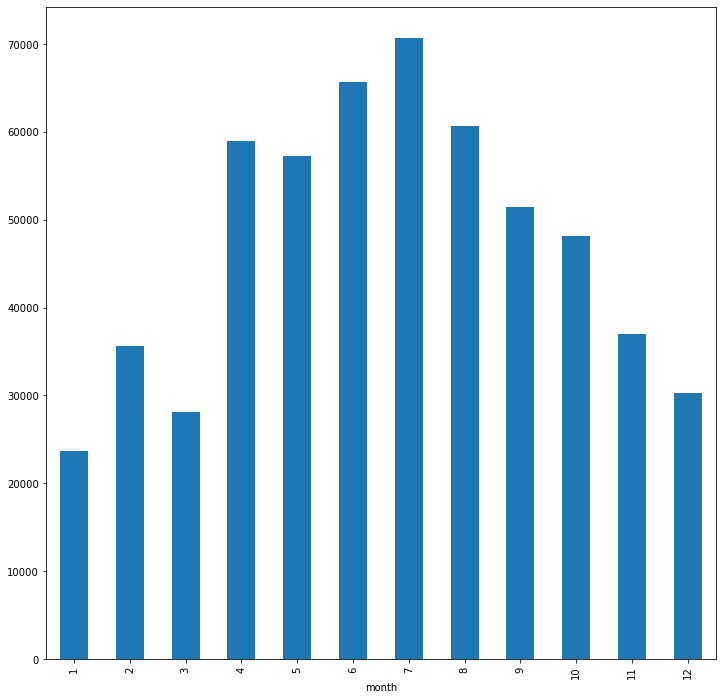

In [36]:
# plot trip number for every month
df_full["month"] = df_full["datetime_start"].dt.month
df_full.groupby(by="month")["datetime_start"].count().plot(kind='bar', figsize=(12,12))

In [37]:
# Compute trip number for every month
df_full[["month", "datetime_start"]].groupby(by="month").count()

,datetime_start
month,
1,23659
2,35632
3,28079
4,58979
5,57239
6,65675
7,70715
8,60696
9,51421


## Visualize trip number for selected months

Text(0.5, 1.0, 'January')

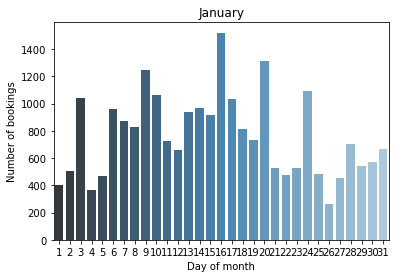

In [38]:
# plot trip number for every day in January
day_of_month_jan = df_full[df_full['datetime_start'].dt.month == 1].datetime_start.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='Day of month') 
ax.set_title('January')

Text(0.5, 1.0, 'February')

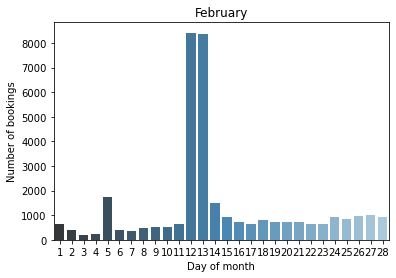

In [39]:
# plot trip number for every day in February (IMPORTANT: There are some extreme points!!! Further analysis necessary!)
day_of_month_jan = df_full[df_full['datetime_start'].dt.month == 2].datetime_start.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='Day of month') 
ax.set_title('February')

Text(0.5, 1.0, 'March')

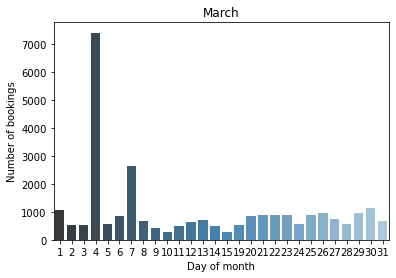

In [40]:
# plot trip number for every day in March (IMPORTANT: There are some extreme points!!! Further analysis necessary!)
day_of_month_jan = df_full[df_full['datetime_start'].dt.month == 3].datetime_start.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='Day of month') 
ax.set_title('March')

Text(0.5, 1.0, 'April')

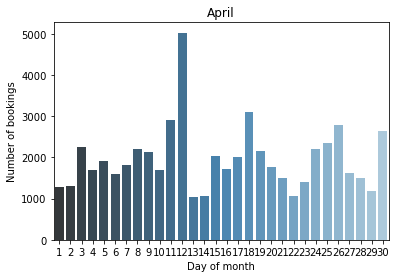

In [41]:
# plot trip number for every day in April (IMPORTANT: There are some extreme points!!! Further analysis necessary!)
day_of_month_jan = df_full[df_full['datetime_start'].dt.month == 4].datetime_start.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='Day of month') 
ax.set_title('April')

Text(0.5, 1.0, 'Jule')

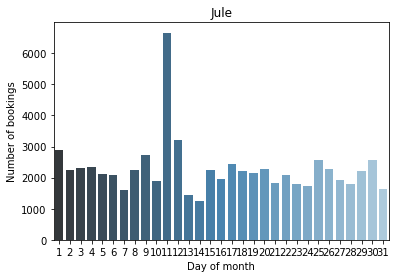

In [42]:
# plot trip number for every day in Jule (IMPORTANT: There are some extreme points!!! Further analysis necessary!)
day_of_month_jan = df_full[df_full['datetime_start'].dt.month == 7].datetime_start.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='Day of month') 
ax.set_title('Jule')

Text(0.5, 1.0, 'October')

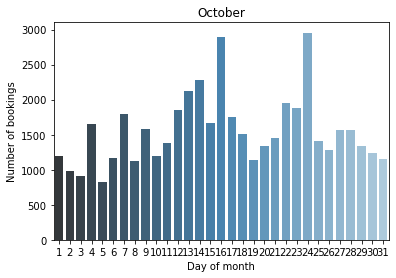

In [43]:
# plot trip number for every day in October (IMPORTANT: There are some extreme points!!! Further analysis necessary!)
day_of_month_jan = df_full[df_full['datetime_start'].dt.month == 10].datetime_start.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='Day of month') 
ax.set_title('October')

## Further plotting

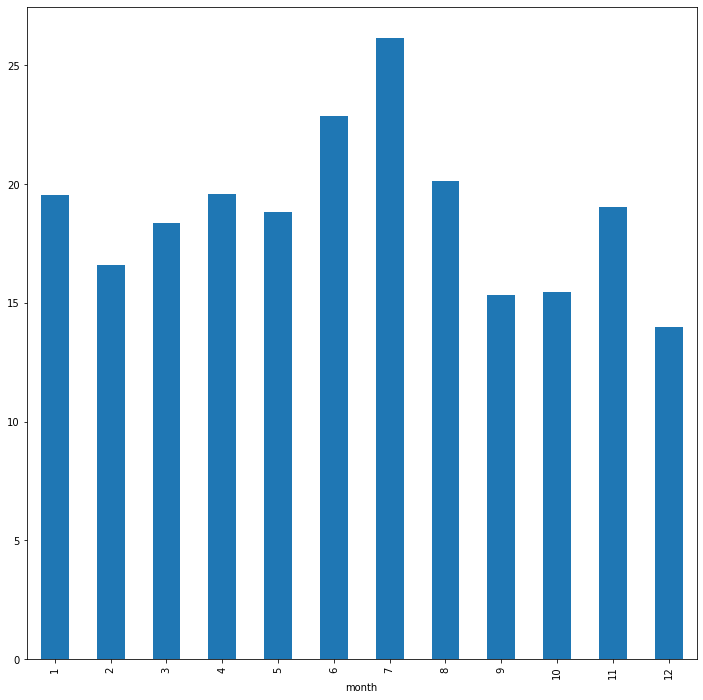

In [44]:
# plot mean trip duration for every month
df_full["month"] = df_full["datetime_start"].dt.month
df_full.groupby(by="month")["trip_duration"].mean().plot(kind='bar', figsize=(12,12))

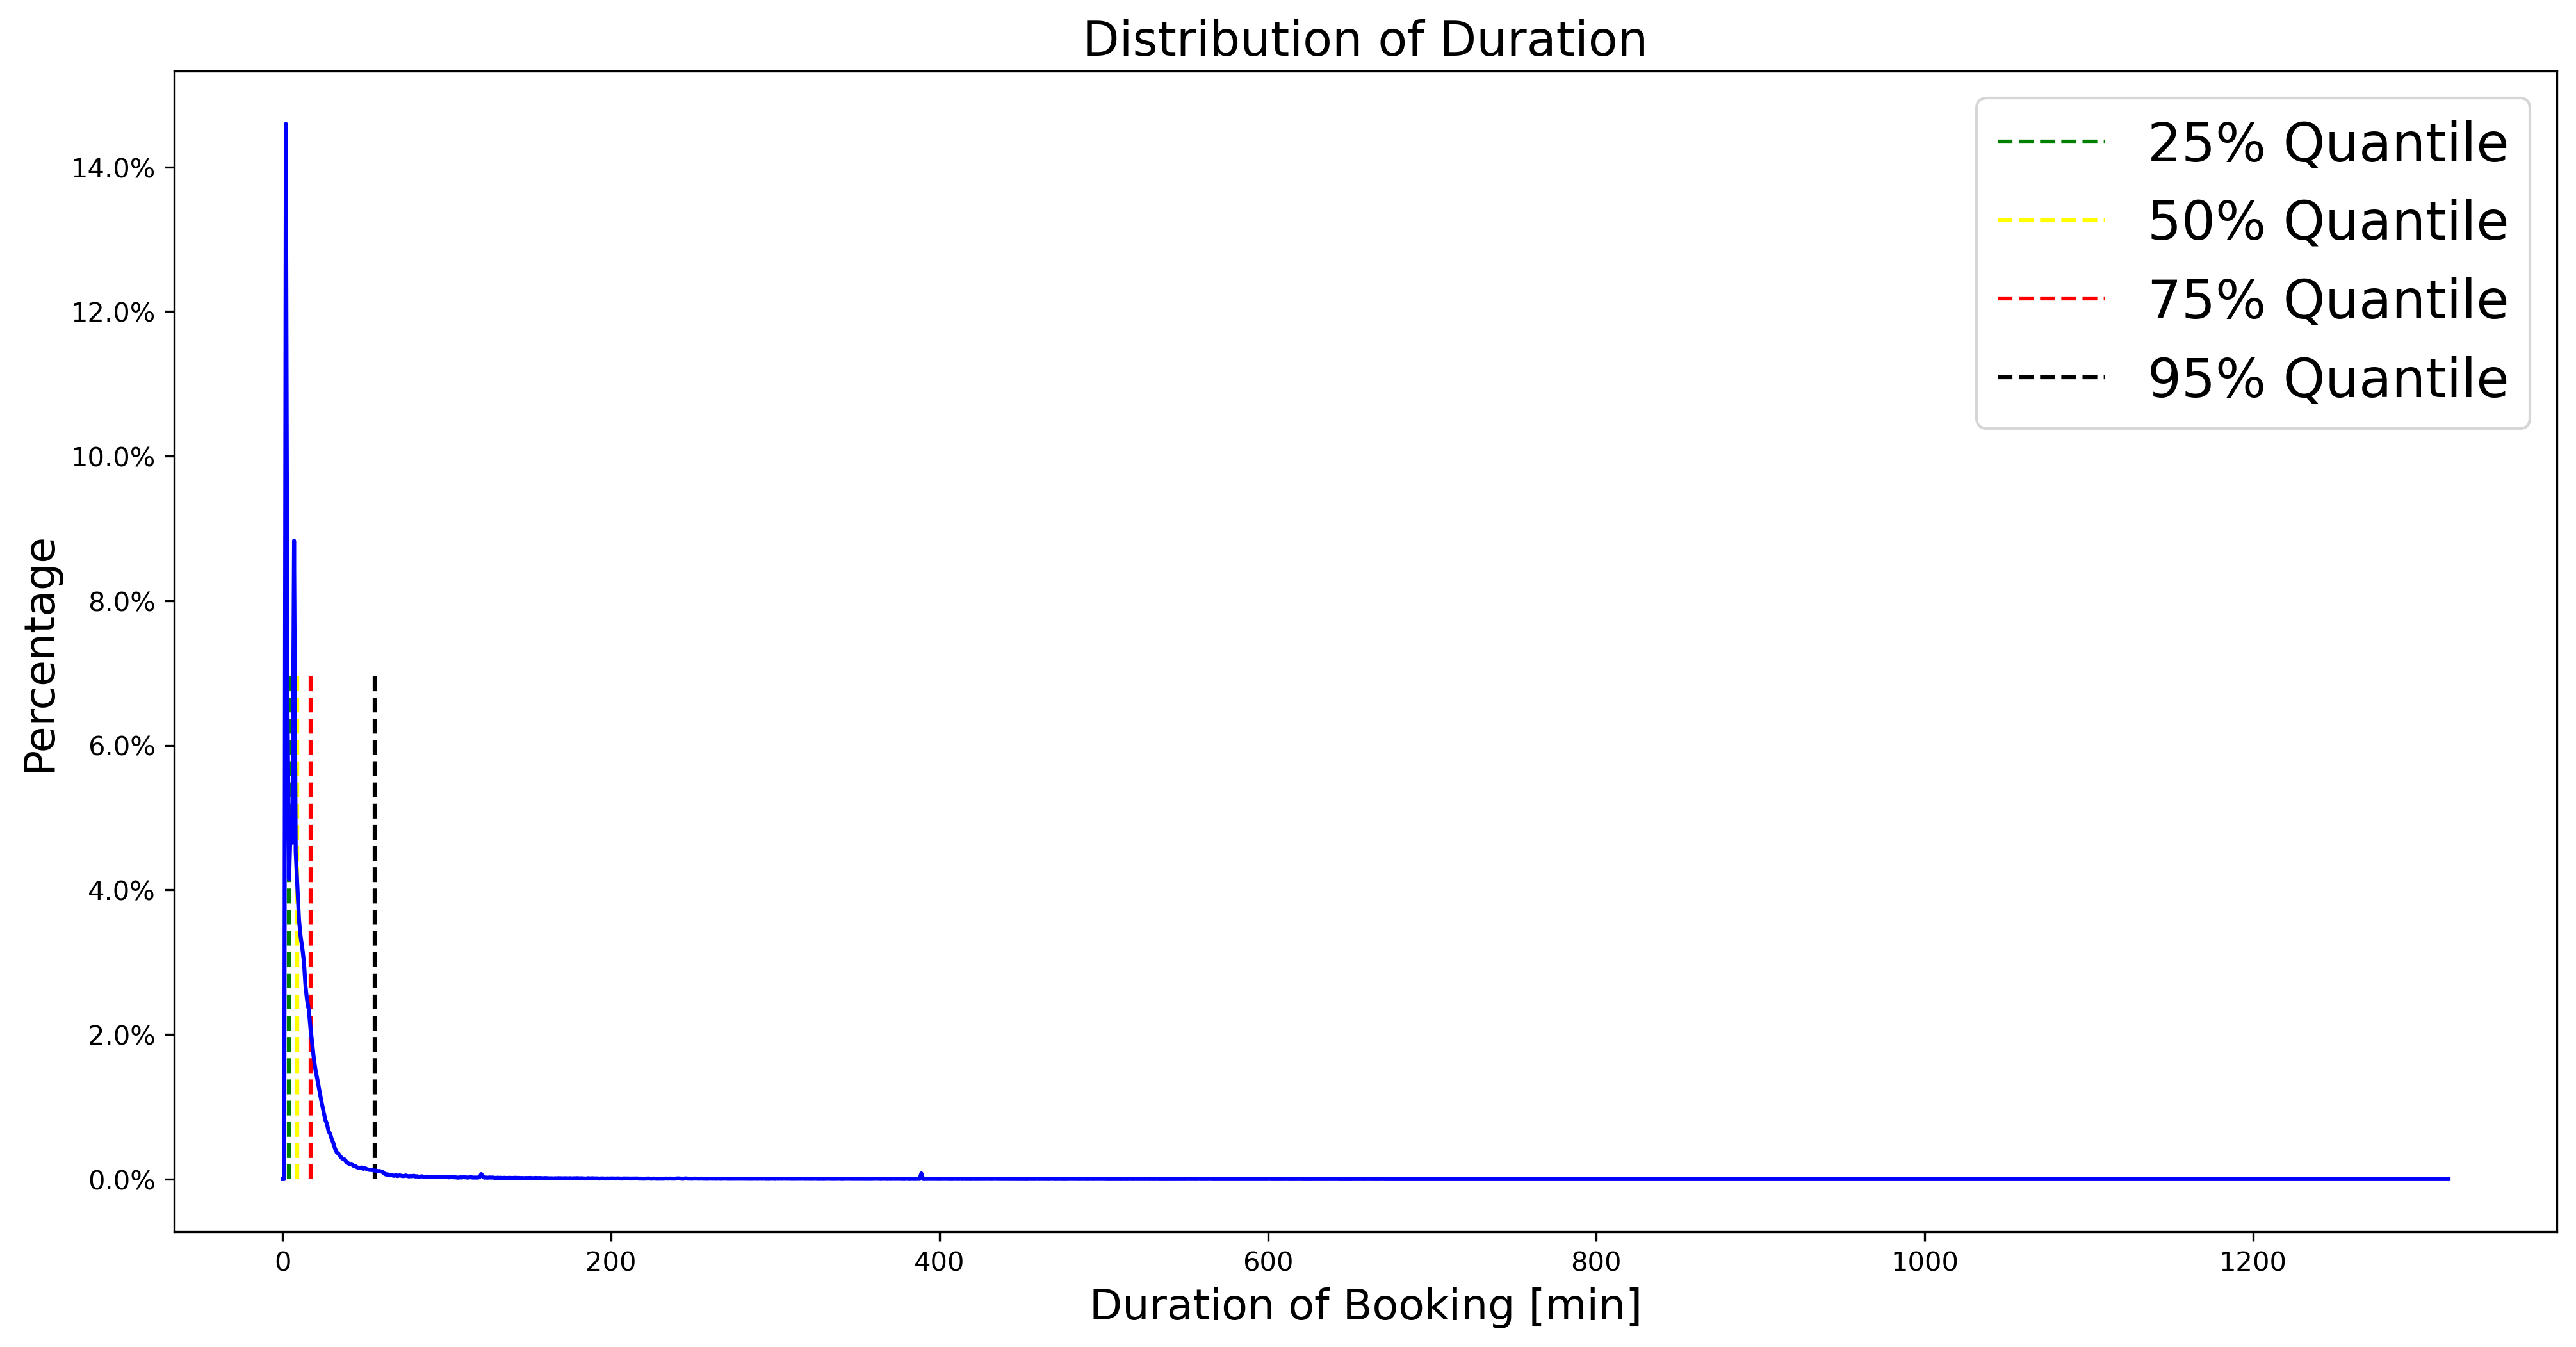

In [45]:
# plot distribution of duration and show quantile borders
# data
duration = df_full["trip_duration"]
values, base = np.histogram(duration, bins=int(duration.max()), range=(0, int(duration.max())), weights=np.ones(len(duration)) / len(duration))
quantile_25 = np.quantile(duration, 0.25)
quantile_50 = np.quantile(duration, 0.5)
quantile_75 = np.quantile(duration, 0.75)
quantile_95 = np.quantile(duration, 0.95)
# plotting
fig, ax = plt.subplots(figsize=(16, 8), dpi=300)
ax.set_xlabel("Duration of Booking [min]", fontsize=16)
ax.set_ylabel("Percentage", fontsize=16)
ax.set_title("Distribution of Duration", fontsize=18)
plt.plot(base[:-1], values, c="blue")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.vlines(quantile_25, 0, 0.07, linestyles="dashed", label="25% Quantile", colors="green")
plt.vlines(quantile_50, 0, 0.07, linestyles="dashed", label="50% Quantile", colors="yellow")
plt.vlines(quantile_75, 0, 0.07, linestyles="dashed", label="75% Quantile", colors="red")
plt.vlines(quantile_95, 0, 0.07, linestyles="dashed", label="95% Quantile")
plt.legend(loc="upper right", prop={"size": 20})
plt.show()

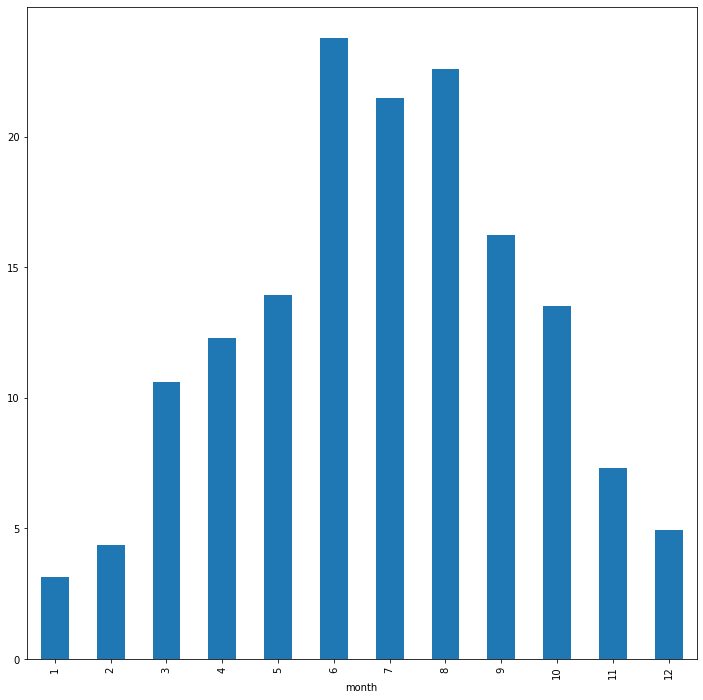

In [46]:
# plot mean air tempretature for every month (analogous for "rain_mm", "rain_yn", "sun_hour" & "wind_ms")
df_full["month"] = df_full["datetime_start"].dt.month
df_full.groupby(by="month")["air_deg"].mean().plot(kind='bar', figsize=(12,12))

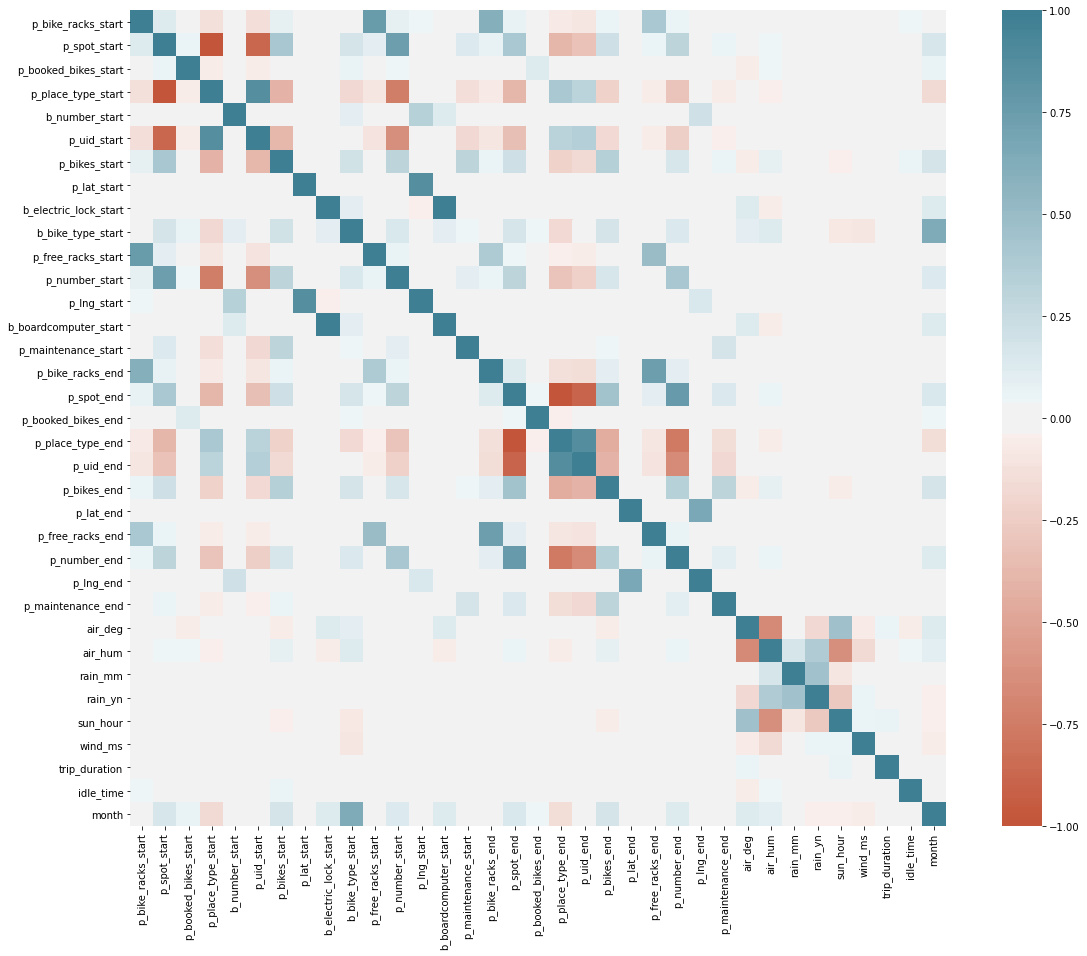

In [47]:
# compute coorelation matrix for the whole dataframe
corrMatrix = df_full.corr()
# plot coorelation matrix for the whole dataframe
plt.subplots(figsize=(20,15))
sns.heatmap(corrMatrix,
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True)
plt.show()